<a href="https://colab.research.google.com/github/maderix/pytorch-notebooks/blob/main/02_pytorch_cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 model
CIFAR10 is slightly more complicated than MNIST. The major difference is the increase in channels - RGB(3) vs Gray(1). So we might need a deeper net.
The good thing is that the dataset loading and training procedure will remain similar.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [2]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                ])

In [4]:
cifar10_trainset = datasets.CIFAR10(root='./data',train=True,download=True, transform=transform)
cifar10_testset = datasets.CIFAR10(root='./data',train=False,download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64 -2.117904 tensor([4, 1, 7, 5, 2, 9, 5, 9, 8, 1, 5, 6, 7, 8, 6, 5, 9, 6, 8, 1, 4, 9, 9, 4,
        0, 0, 5, 8, 5, 5, 3, 9, 1, 9, 8, 6, 3, 1, 5, 4, 6, 8, 9, 3, 0, 9, 0, 0,
        5, 8, 1, 1, 6, 9, 9, 8, 7, 8, 7, 4, 9, 5, 4, 2])


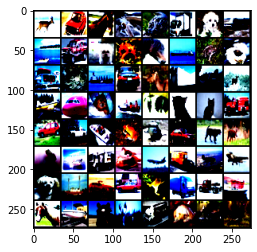

In [6]:
import numpy as np
import matplotlib.pyplot as plt
images,labels = next(iter(train_loader))
print(np.max(images.numpy()),np.min(images.numpy()),labels)
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

# Creating the network
We'll create a simple CNN which takes a 32x32x3 size images and returns a probability distribution of 10 classes. This is very similar to the MNIST task.

In [27]:
class CIFARNet(nn.Module):
  def __init__(self):
    super(CIFARNet,self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, 1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 3, 1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 3, 1)
    self.bn4 = nn.BatchNorm2d(256)

    self.dropout1 = nn.Dropout2d(0.25)
    #self.dropout2 = nn.Dropout(0.5)

    #fully connected layers for categorizing the image features
    self.fc1 = nn.Linear(256*12*12, 128)
    self.fc2 = nn.Linear(128, 10)
  #forward function will determine how data passes through our model
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    #second block
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    #Third block
    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    #Fourth block
    x = self.conv4(x)
    x = self.bn4(x)
    x = F.relu(x)
    #create a maxpooling layer to reduce the compute requirements
    x = F.max_pool2d(x , 2)
    # pass data through the dropouts
    #x = self.dropout1(x)
    #flatten the data so that it can pass through fc layers
    x = torch.flatten(x,1)
    #fully connected/dense block.
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    #we'll apply softmax to the final output to get nice probabilities for each digit
    output = F.log_softmax(x,dim=1)
    return output
    
cnet = CIFARNet()
print(cnet)

CIFARNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=36864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Random test
Let's do a random test to test the forward function of our net


In [28]:
random_data = torch.randn((1, 3, 32, 32))
result = cnet(random_data)
print(result)

tensor([[-2.3058, -2.0429, -2.1701, -2.6527, -2.2328, -2.0961, -2.7632, -2.4916,
         -2.1564, -2.3616]], grad_fn=<LogSoftmaxBackward>)


# Training pipeline
Let's define our CIFAR training pipeline, which is quite similar to the MNIST one. Therein lies the power of neural nets, a model can fit multiple datasets. Accuracy may vary according to the complexity of the dataset but tuning may help correct this.

1.   Get model output with current input
2.   Calculate loss
3.   Calculate gradients
4.   Update weights through optimizer

the 'to(device)' function will allow us to place the tensor on GPU if available.

In [40]:
import tqdm

net = CIFARNet()
learning_rate = 1e-4
epochs = 40
#we use Adam optimizer as it converges faster compared to SGD
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [41]:
net = net.to(device)
#zero out the gradients
for epoch in range(epochs):
  net.train()
  t = tqdm.tqdm(train_loader,leave=True, position=0)
  for images,labels in t:
    images = images.to(device)
    labels = labels.long().to(device)
    optimizer.zero_grad()
    output = net.forward(images)
    train_loss = criterion(output,labels)
    train_loss.backward()
    optimizer.step()
    t.set_description(f'epoch:{epoch+1} : train loss:{train_loss.item():.4f}')
    t.refresh()
  #evaluate after each epoch
  net.eval()
  images,labels = next(iter(test_loader))
  images = images.to(device)
  labels = labels.to(device)
  with torch.no_grad():
    output = net(images)
    valid_loss = criterion(output,labels)
    print(f'epoch:{epoch+1} : valid loss:{valid_loss.item():.4f}\n')

epoch:2 : train loss:1.3437:   1%|          | 4/782 [00:00<00:24, 31.81it/s]

epoch:1 : valid loss:0.9379



epoch:3 : train loss:1.0390:   0%|          | 3/782 [00:00<00:26, 29.60it/s]

epoch:2 : valid loss:0.7416



epoch:4 : train loss:1.0124:   1%|          | 4/782 [00:00<00:25, 31.07it/s]

epoch:3 : valid loss:0.5607



epoch:5 : train loss:0.7501:   1%|          | 4/782 [00:00<00:24, 31.71it/s]

epoch:4 : valid loss:0.5470



epoch:6 : train loss:0.6149:   0%|          | 3/782 [00:00<00:27, 28.40it/s]

epoch:5 : valid loss:0.5520



epoch:7 : train loss:0.5686:   1%|          | 4/782 [00:00<00:24, 32.18it/s]

epoch:6 : valid loss:0.4869



epoch:8 : train loss:0.5113:   1%|          | 4/782 [00:00<00:24, 31.52it/s]

epoch:7 : valid loss:0.4383



epoch:9 : train loss:0.8384:   1%|          | 4/782 [00:00<00:24, 32.02it/s]

epoch:8 : valid loss:0.4596



epoch:10 : train loss:0.4519:   1%|          | 4/782 [00:00<00:24, 31.81it/s]

epoch:9 : valid loss:0.4249



epoch:11 : train loss:0.5641:   1%|          | 4/782 [00:00<00:24, 32.31it/s]

epoch:10 : valid loss:0.3869



epoch:12 : train loss:0.3690:   1%|          | 4/782 [00:00<00:24, 31.78it/s]

epoch:11 : valid loss:0.4084



epoch:13 : train loss:0.3003:   1%|          | 4/782 [00:00<00:24, 31.37it/s]

epoch:12 : valid loss:0.5207



epoch:14 : train loss:0.3129:   1%|          | 4/782 [00:00<00:24, 32.05it/s]

epoch:13 : valid loss:0.4101



epoch:15 : train loss:0.3737:   1%|          | 4/782 [00:00<00:24, 31.61it/s]

epoch:14 : valid loss:0.2706



epoch:16 : train loss:0.2953:   1%|          | 4/782 [00:00<00:25, 30.90it/s]

epoch:15 : valid loss:0.4564



epoch:17 : train loss:0.3043:   1%|          | 4/782 [00:00<00:24, 31.26it/s]

epoch:16 : valid loss:0.3667



epoch:18 : train loss:0.2018:   0%|          | 3/782 [00:00<00:26, 29.28it/s]

epoch:17 : valid loss:0.3717



epoch:19 : train loss:0.2346:   1%|          | 4/782 [00:00<00:25, 30.41it/s]

epoch:18 : valid loss:0.4715



epoch:20 : train loss:0.2732:   1%|          | 4/782 [00:00<00:24, 31.65it/s]

epoch:19 : valid loss:0.4388



epoch:21 : train loss:0.2439:   0%|          | 3/782 [00:00<00:26, 29.66it/s]

epoch:20 : valid loss:0.4469



epoch:22 : train loss:0.1779:   1%|          | 4/782 [00:00<00:25, 31.04it/s]

epoch:21 : valid loss:0.3891



epoch:23 : train loss:0.2501:   1%|          | 4/782 [00:00<00:24, 31.22it/s]

epoch:22 : valid loss:0.6160



epoch:24 : train loss:0.1194:   1%|          | 4/782 [00:00<00:24, 31.86it/s]

epoch:23 : valid loss:0.4393



epoch:25 : train loss:0.1174:   1%|          | 4/782 [00:00<00:24, 31.71it/s]

epoch:24 : valid loss:0.3963



epoch:26 : train loss:0.1198:   1%|          | 4/782 [00:00<00:24, 31.66it/s]

epoch:25 : valid loss:0.4807



epoch:27 : train loss:0.1874:   1%|          | 4/782 [00:00<00:25, 30.90it/s]

epoch:26 : valid loss:0.4244



epoch:28 : train loss:0.2347:   1%|          | 4/782 [00:00<00:24, 32.01it/s]

epoch:27 : valid loss:0.6448



epoch:29 : train loss:0.1575:   1%|          | 4/782 [00:00<00:24, 31.19it/s]

epoch:28 : valid loss:0.4040



epoch:30 : train loss:0.1103:   0%|          | 3/782 [00:00<00:26, 29.89it/s]

epoch:29 : valid loss:0.5665



epoch:31 : train loss:0.1445:   1%|          | 4/782 [00:00<00:24, 31.27it/s]

epoch:30 : valid loss:0.5538



epoch:32 : train loss:0.1692:   1%|          | 4/782 [00:00<00:25, 30.99it/s]

epoch:31 : valid loss:0.4914



epoch:33 : train loss:0.1281:   1%|          | 4/782 [00:00<00:25, 30.45it/s]

epoch:32 : valid loss:0.6031



epoch:34 : train loss:0.0573:   0%|          | 3/782 [00:00<00:26, 29.33it/s]

epoch:33 : valid loss:0.4965



epoch:35 : train loss:0.1532:   1%|          | 4/782 [00:00<00:24, 32.02it/s]

epoch:34 : valid loss:0.6687



epoch:36 : train loss:0.1042:   1%|          | 4/782 [00:00<00:24, 32.03it/s]

epoch:35 : valid loss:0.4461



epoch:37 : train loss:0.0922:   1%|          | 4/782 [00:00<00:24, 31.95it/s]

epoch:36 : valid loss:0.2917



epoch:38 : train loss:0.0952:   0%|          | 3/782 [00:00<00:27, 28.80it/s]

epoch:37 : valid loss:0.6955



epoch:39 : train loss:0.0655:   0%|          | 3/782 [00:00<00:26, 29.95it/s]

epoch:38 : valid loss:0.7403



epoch:40 : train loss:0.2770:   1%|          | 4/782 [00:00<00:24, 31.95it/s]

epoch:39 : valid loss:0.4664



epoch:40 : train loss:0.0677: 100%|██████████| 782/782 [00:26<00:00, 29.96it/s]


epoch:40 : valid loss:0.4180



# Test accuracy

In [42]:
test_loss = 0
class_correct,class_total = [0]*10, [0] *10
#we'll load the weights from first network
net_eval=CIFARNet()
net_eval.load_state_dict(net.state_dict())
net_eval.eval()

for images,targets in test_loader:
  with torch.no_grad():
    output = net_eval(images)
    loss = criterion(output, targets)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(targets.data.view_as(pred)))
    for i in range(len(targets)):
        label = targets.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')
print(f'Test accuracy: {np.sum(class_correct)/np.sum(class_total)*100} %')

Test Loss: 1.230928
Test accuracy: 75.52 %
